# 2.1 Transit light curve analysis of WASP-12b 

### Universidad de La Laguna Exo & Exo 2023 exercise 2

Author: [Hannu Parviainen](mailto:hannu@iac.es)<br>
Last updated: 17.4.2023

## Initialisation

In [1]:
%matplotlib inline 

In [2]:
import math as mt
import pandas as pd
import warnings
import seaborn as sb

from matplotlib.pyplot import subplots, setp, rc, Rectangle
from numpy import argmax, array, median, seterr, floor, percentile
from numpy.random import seed, permutation
from astropy.table import Table
from corner import corner

from pytransit import TransitLPF

seterr('ignore')
seed(0)

### Read in the data

First we need to read in the light curve stored in ``wasp-12b_181227_chromatic_k.fits``. The file has light curves for a single transit observed simultaneously in four passbands (g, r, i, and z_s), but we keep things simple and use only the r-band data. 

In our case, the photometry is saved as binary table extensions in the fits file, one extension per passband. To get the r-band data, we need to read the third HDU of the fits file (the first is the primary HDU, the second the first extension, etc.).

We start the same way as with the RV data and take a look at our data and try plotting it.

In [3]:
tb = Table.read('data/wasp-12b_181227_chromatic_k.fits', 2)
tb[:5]

time_bjd,flux,flux_rel,flux_trg,flux_ref,baseline,model
float64,float64,float64,float64,float64,float64,float64
2458480.557361179,1.0001350941062013,1.016282780690799,1.0234186998514527,1.0070215881802143,1.0161455054219737,1.0
2458480.558397079,1.0000222850175708,1.0167163747091499,1.0256873377854854,1.0088234667007323,1.0166937176717874,1.0
2458480.5587828704,0.999633046547194,1.0162828378132795,1.0244264276468822,1.0080131136044028,1.016655903207277,1.0
2458480.5594445122,1.0004227218395325,1.0169303171289636,1.0232086525273774,1.0061738108232814,1.016500620116942,1.0
2458480.5602084063,0.9981259684100012,1.0146302762017558,1.021813766379826,1.0070799091516973,1.0165352954577924,1.0


Now, we can assume the time data is stored in the ``time_bjd`` column and the flux the ``flux`` column. In general, if you'd see a file like this, you should check the file's documentation (if such exists) what column is what, or ask the person who created the file.

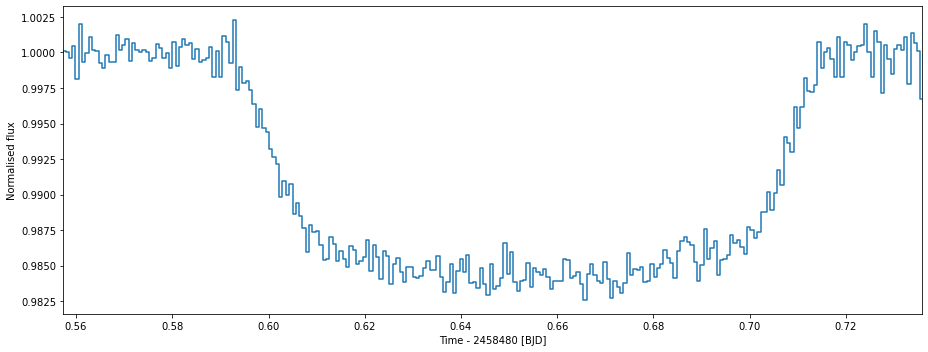

In [4]:
tref = floor(tb['time_bjd'].mean())
fig, ax = subplots(figsize=(13,5), sharey=True)
ax.plot(tb['time_bjd'] - tref, tb['flux'], drawstyle='steps-mid')
setp(ax, xlabel=f"Time - {tref:.0f} [BJD]", ylabel='Normalised flux', xlim=tb['time_bjd'][[0,-1]]-tref)
fig.tight_layout()

## Parameter estimation

First, we create an instance of the log posterior function with the redmost light curve data.

Next, we run the *DE* optimiser for ``de_iter`` iterations to clump the parameter vector population close to the global posterior maximum, use the *DE* population to initialise the *emcee* sampler, and run the sampler for ``mc_iter`` iterations to obtain a posterior sample.

### Initialise the LPF and set the priors

In [5]:
lpf = TransitLPF('WASP-12b', 'r', tb['time_bjd'], tb['flux'])
lpf.ps
#k2 is the area ratio between area of the star and area of the planet
#rho is the density of the star
#wn_loge_0 is related with the noise

[  0 |G| tc             N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p              N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

In [6]:
lpf.set_prior('tc', 'NP', 2458480.65, 0.02)
lpf.set_prior('p', 'NP', 1.0914201, 1.1e-09)

In [7]:
lpf.ps

[  0 |G| tc             N(μ = 2458480.65, σ = 0.02)              [    -inf ..      inf],
   1 |G| p              N(μ = 1.0914201, σ = 1.1e-09)            [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

Global optimisation:   0%|          | 0/1000 [00:00<?, ?it/s]

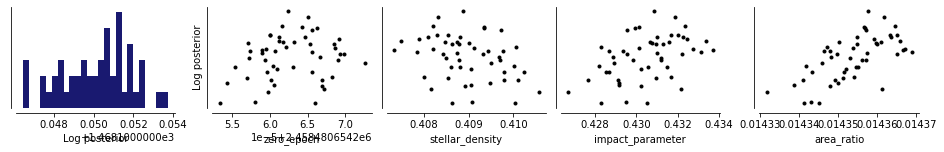

In [8]:
lpf.optimize_global(niter=1000, npop=50)

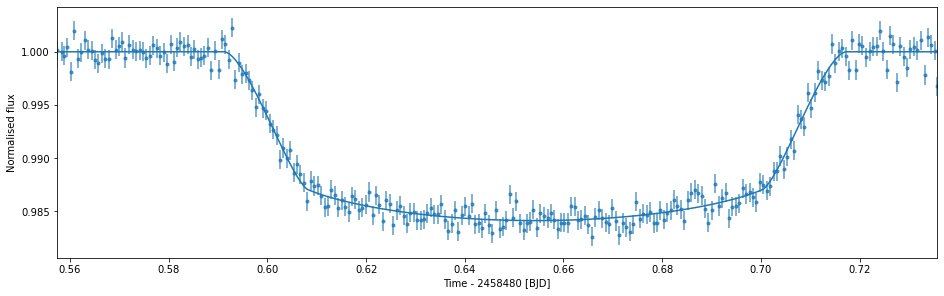

In [9]:
lpf.plot_light_curve();

In [10]:
lpf.sample_mcmc(5000, thin=20, repeats=2, label='MCMC sampling')

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/5000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/5000 [00:00<?, ?it/s]

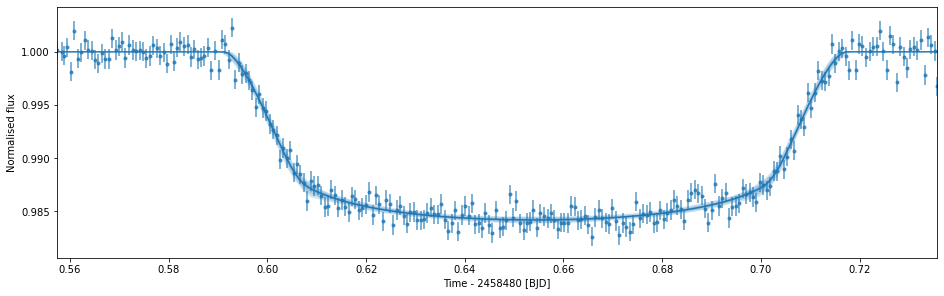

In [11]:
lpf.plot_light_curve('mc');

### Analysis: overview

The MCMC chains are now stored in ``lpf.sampler.chain``. Let's first have a look into how the chain populations evolved to see if we have any problems with our setup, whether we have converged to sample the true posterior distribution, and, if so, what was the burn-in time.

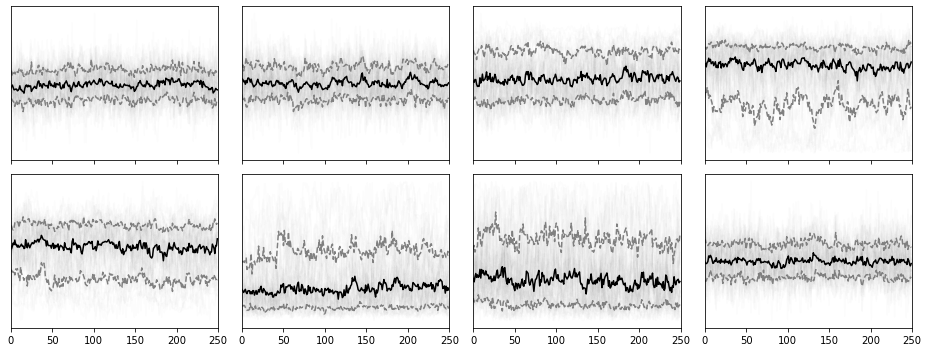

In [12]:
fig, axs = subplots(2,4, figsize=(13,5), sharex=True)
ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
percs = [percentile(lpf.sampler.chain[:,:,i], [50,16,84], 0) for i in range(8)]
[axs.flat[i].plot(lpf.sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(8)]
[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(8)]
setp(axs, yticks=[], xlim=[0,5000//20])
fig.tight_layout()

Ok, everything looks good. The 16th, 50th and 84th percentiles of the parameter vector population are stable and don't show any significant long-term trends. Now we can flatten the individual chains into one long chain ``fc`` and calculate the median parameter vector.

In [13]:
fc = lpf.sampler.chain.reshape([-1,lpf.sampler.chain.shape[-1]])
mp = median(fc, 0)

Let's also plot the model and the data to see if this all makes sense. To do this, we calculate the conditional distribution of flux using the posterior samples (here, we're using a random subset of samples, although this isn't really necessary), and plot the distribution median and it's median-centred 68%, 95%, and 99.7% central posterior intervals (corresponding approximately to 1, 2, and 3$\sigma$ intervals if the distribution is normal). 

In [14]:
flux_pr = lpf.flux_model(fc[permutation(fc.shape[0])[:1000]])
flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))

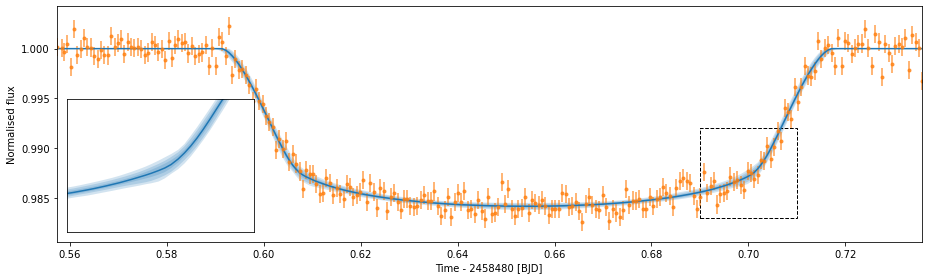

In [15]:
zx1,zx2,zy1,zy2 = 0.69,0.71, 0.983, 0.992
tref = floor(lpf.timea.min())
fig, ax = subplots(1,1, figsize=(13,4))
ax.errorbar(lpf.timea-tref, lpf.ofluxa, 10**mp[7], fmt='.', c='C1', alpha=0.75)
[ax.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
ax.plot(lpf.timea-tref, flux_pc[0], c='C0')
setp(ax, xlim=lpf.timea[[0,-1]]-tref, xlabel=f'Time - {tref:.0f} [BJD]', ylabel='Normalised flux')
fig.tight_layout()

az = fig.add_axes([0.075,0.18,0.20,0.46])
ax.add_patch(Rectangle((zx1,zy1),zx2-zx1,zy2-zy1,fill=False,edgecolor='k',lw=1,ls='dashed'))
[az.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
setp(az, xlim=(zx1,zx2), ylim=(zy1,zy2), yticks=[], xticks=[])
az.plot(lpf.timea-tref, flux_pc[0], c='C0');

We could (should) also plot the residuals, but I've left them out from the plot for clarity. The plot looks fine, and we can continue to have a look at the parameter estimates.

## Analysis

We start the analysis by making a Pandas data frame ``df``, using the ``df.describe`` to gen an overview of the estimates, and plotting the posteriors for the most interesting parameters as violin plots.

In [16]:
pd.set_option('display.precision',4)
df = lpf.posterior_samples(derived_parameters=True)
df.describe()

,tc,p,rho,b,k2,q1_r,q2_r,wn_loge_0,k,a,inc,t14,t23
count,1.2500e+04,1.2500e+04,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000
mean,2.4585e+06,1.0914e+00,0.4348,0.3345,0.0140,0.3201,0.3417,-3.0412,0.1181,3.0117,1.4582,0.1258,0.0946
std,1.5905e-04,1.0778e-09,0.0366,0.1246,0.0005,0.2026,0.2342,0.0194,0.0020,0.0845,0.0440,0.0010,0.0026
min,2.4585e+06,1.0914e+00,0.3150,0.0004,0.0127,0.0451,0.0002,-3.1082,0.1128,2.7069,1.3523,0.1221,0.0864
25%,2.4585e+06,1.0914e+00,0.4072,0.2692,0.0136,0.1628,0.1545,-3.0546,0.1167,2.9489,1.4256,0.1251,0.0926
50%,2.4585e+06,1.0914e+00,0.4322,0.3692,0.0140,0.2617,0.2875,-3.0420,0.1184,3.0080,1.4479,0.1258,0.0943
75%,2.4585e+06,1.0914e+00,0.4623,0.4267,0.0143,0.4307,0.4838,-3.0286,0.1196,3.0762,1.4834,0.1264,0.0967
max,2.4585e+06,1.0914e+00,0.5357,0.5867,0.0152,0.9982,0.9996,-2.9523,0.1232,3.2312,1.5707,0.1296,0.1010


<AxesSubplot:>

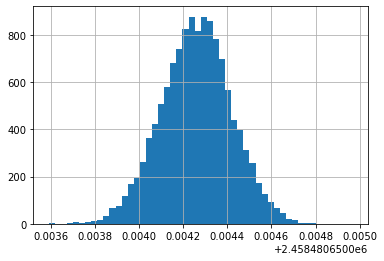

In [17]:
df.tc.hist(bins=50)

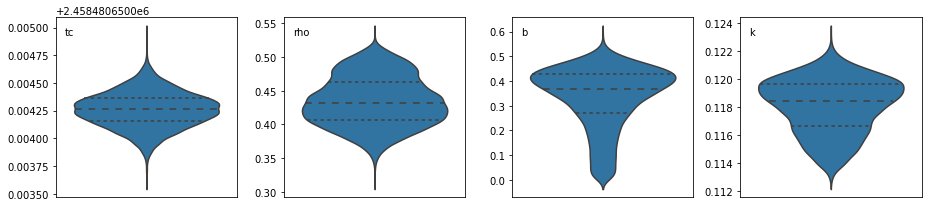

In [18]:
fig, axs = subplots(1,4, figsize=(13,3))
pars = 'tc rho b k'.split()
[sb.violinplot(y=df[p], inner='quartile', ax=axs.flat[i]) for i,p in enumerate(pars)]
[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(pars)]
setp(axs, xticks=[], ylabel='')
fig.tight_layout()

While we're at it, let's plot some correlation plots. The limb darkening coefficients are correlated, and we'd also expect to see a correlation between the impact parameter and radius ratio.

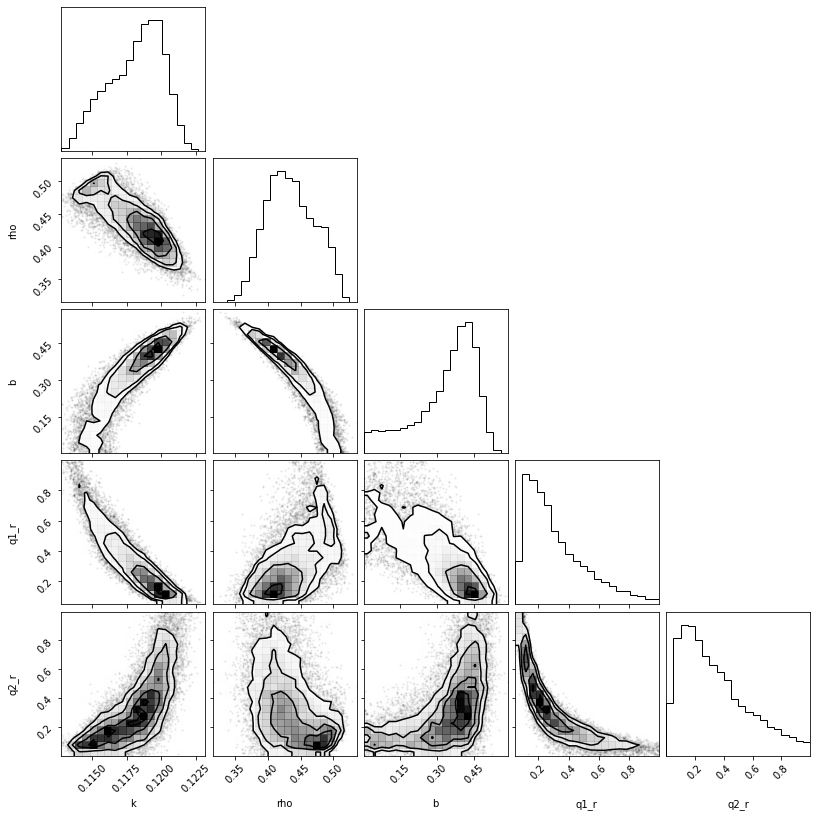

In [19]:
ccols = ['k', 'rho', 'b', 'q1_r', 'q2_r']
corner(df[ccols], labels=ccols);

### <span style="color:darkblue">Questions and exercises</span>

Student: Ignacio Ruiz Cejudo

1. Estimate the radius of the planet using the planet-star radius ratio (k) and the stellar radius (that you need to find from somewhere ;)) Give the answer in Jupiter radii.

We have the planet-star radius ratio, $k=\frac{R_{p}}{R_{*}}$. So we only need to find out the radius of the star:
$$
R_{p}=k\cdot R_{*}=k\cdot1.57R_{\odot}
$$

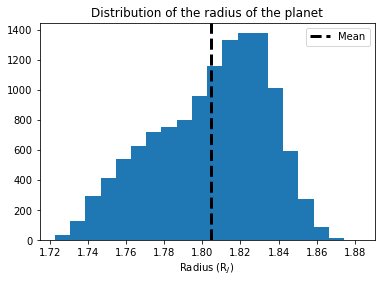

Rpl = 1.8043893154313988±0.00026691050004923035


In [20]:
import numpy as np
import matplotlib.pyplot as plt
Rwasp=1.57*6.957e8 #m
Rjup=71492000 #m
k=df['k'].to_numpy()#to put it in an array
Rpl=k*Rwasp/Rjup
Rpl_mn=np.mean(Rpl)
eRpl_mn=np.std(Rpl)/np.sqrt(len(Rpl)) #We define the error as sigma/sqrt(N)
plt.hist(Rpl,bins=20)
plt.xlabel(r'Radius (R$_{J}$)')
plt.title('Distribution of the radius of the planet')
plt.axvline(x=Rpl_mn,ymin=0,ymax=1,linestyle='--',linewidth=3,color='k',label='Mean')
plt.legend()
plt.show()

print('Rpl = '+str(Rpl_mn)+'±'+str(eRpl_mn))

The radius of the planet is
$$
R_{p}=(1.8035\pm0.0003)\rm{R_{J}}
$$

2. Compare the stellar density ($\rho$) estimated from the transit modelling to the theoretical stellar density for a WASP-12-like star.

- The mean density of the star is (using the same error estimation as before):

$$
\overline{\rho_{*}}=(0.43753\pm0.00033)\rm{g cm^{-3}}
$$

Theoretically, we know that this is a G0V star (from SIMBAD). The typicall mass and radius of a G0V star are $1.06M_{\odot}$ and $1.1R_{\odot}$. We can derive a uniform density of $\rho_{G0V}=1.118\rm{g cm^{-3}}$, three times bigger than the star we are studying. On the other hand, the mass of this star is 1.35$M_{\odot}$, leading to a uniform density of $0.490\rm{g cm^{-3}}$, more similar with the one we are measuring from this model.


3. From the plot above you can see that many of the parameters are correlated with each other. What does this mean in practice?

- This can mean 2 different things in practice:
    1) On one hand, we are measuring all the parameters together taking into account they are not independent. This can be leading to an artificial correlation (not really likely).
    2) On the other hand, if this is physical, we can see some things:
    
    The impact parameter depends on the radius of the star and the radius of the planet. At the end, this means that the impact parameter should be dependent on the ratio of radius. In case of the stellar density, we see that a higher ratio between radius means a lower stellar density. This is a bit strange, since we can think that a decrease of the stellar radius (i.e., an increase of the ratio $k$) will mean an increase of the stellar density. However, this also would affect on the orbit of the planet, and the mass and radius a planet can have at this orbit. So, every parameter is connected to the orbit of the planet around the star.


In [21]:
rho_star=df['rho'].to_numpy()
print(str(np.mean(rho_star))+'±'+str(np.std(rho_star)/np.sqrt(len(rho_star))))

0.4348417829074497±0.0003272266243445976


In [22]:
Mgov=1.06*1.98e33 #g
Rgov=1.1*6.957e10 #cm
rhogov=3*Mgov/(4*np.pi*Rgov**3)
rhogov

1.11799118856354

In [23]:
Mwas=1.35*1.98e33
rhowas=3*Mwas/(4*np.pi*(Rwasp*100)**3)
rhowas

0.489717227560418

---
<center>&copy; Hannu Parviainen 2014&ndash;2023</center>